<a href="https://colab.research.google.com/github/ehtasham/emotion-classification/blob/main/Using_Distilbert_for_emotion_classification_using_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers datasets torch

In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from huggingface_hub import HfApi
from datasets import load_dataset
from transformers import AutoModel
from transformers import AutoTokenizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [3]:
api = HfApi()

In [4]:
all_datasets = list(api.list_datasets())

In [5]:
len(all_datasets)

90761

### load and explore dataset


In [6]:
emotions =load_dataset("emotion")

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/emotion
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [7]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [8]:
train_ds = emotions['train']
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [9]:
train_ds.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}

In [10]:
train_ds.column_names

['text', 'label']

In [11]:
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [12]:
emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [13]:
def label_int2str(row):
  return emotions["train"].features["label"].int2str(row)
df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


### Looking at the Class Distribution

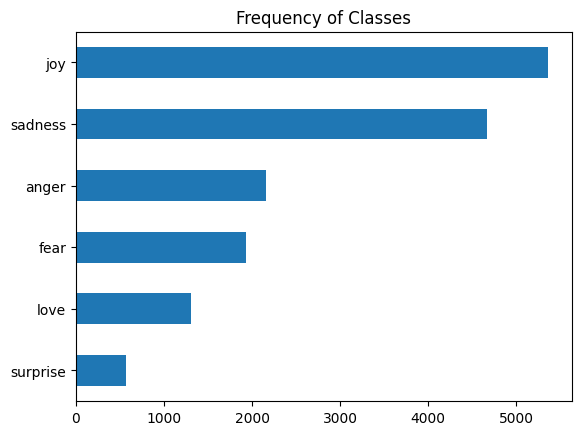

In [14]:
import matplotlib.pyplot as plt
df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

In [15]:
emotions.reset_format()

### Tokenization

In [16]:
model_ckpt = "distilbert-base-uncased"

In [ ]:
# initialize the Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [22]:
# - This function applies the tokenizer to a batch of examples;
# - padding=True will pad the examples with zeros to the size of the longest one in a batch
# - truncation=True will truncate the examples to the model’s maximum context size
def tokenize(batch):
  """ Tokenize a whole batch """
  return tokenizer(batch["text"], padding=True, truncation=True)

In [ ]:
# - use map function to tokenize the whole dataset
# - By default, the map() method operates individually on every example in the corpus.
# - so setting batched=True will encode the tweets in batches.
# - Because we’ve set batch_size=None, our tokenize() function will be applied on the full dataset as a single batch.
# - This ensures that the input tensors and attention masks have the same shape globally.
# - and we can see that this operation has added new input_ids and attention_mask columns to the dataset
# - the attention mask allows the model to ignore the padded parts of the input.
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

In [24]:
# place model on device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [31]:
def extract_hidden_states(batch):
  """ Extract hidden states of the whole batch """
  # Place model inputs on the device
  inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
  # Extract last hidden states
  with torch.no_grad():
      # pass the inputs to the model with torch.no_grad() context manager to disable the automatic calculation of the gradient.
      # This is useful for inference since it reduces the memory footprint of the computations.
      last_hidden_state = model(**inputs).last_hidden_state
      # Return vector for [CLS] token
      # For classification tasks, it is common practice to just use the hidden state associated with the [CLS] token as the input feature.
      # we place the final hidden state back on the CPU as a NumPy array.
      # The map() method requires the processing function to return Python or NumPy objects when we’re using batched inputs.
      return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [32]:
# Since our model expects tensors as inputs, the next thing to do is convert the
# input_ids and attention_mask columns to the "torch" format, as follows:
emotions_encoded.set_format("torch",columns=["input_ids", "attention_mask", "label"])

In [33]:
# extract the hidden states
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [34]:
# Use the hidden states as input features and the labels as targets.
X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape


((16000, 768), (2000, 768))

In [35]:
# Train the classifier
# We increase `max_iter` to guarantee convergence
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.633

In [36]:
def plot_confusion_matrix(y_preds, y_true, labels):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
  plt.title("Normalized confusion matrix")
  plt.show()

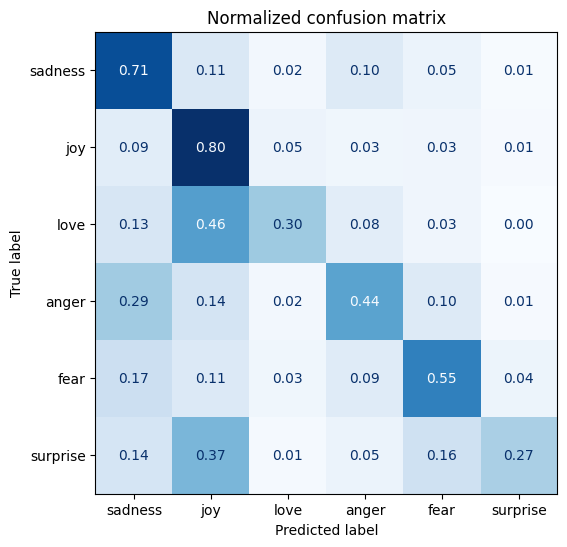

In [37]:
y_preds = lr_clf.predict(X_valid)
labels = emotions["train"].features["label"].names
plot_confusion_matrix(y_preds, y_valid, labels)